## Forecasting a Pure Sinusoid

In [1]:
import numpy as np
import matplotlib.pyplot as plt

SAMPLE_RATE = 44100  # Hertz
DURATION = 10  # Seconds

# https://realpython.com/python-scipy-fft/#using-the-fast-fourier-transform-fft
def generate_sine_wave(freq, sample_rate, duration):
    t = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = t * freq
    Z = np.sin((2 * np.pi) * frequencies)
    return t, Z

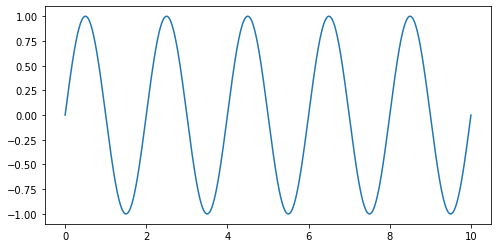

In [2]:
# Generate a 2 Hz sine wave that lasts for 5 seconds
t, Z = generate_sine_wave(0.5, SAMPLE_RATE, DURATION)

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(t, Z)
plt.show()

In [3]:
print(Z.shape)

(441000,)


## Forecasting Time-Series via Recurrent Neural Networks (RNNs)

In [4]:
import random
import torch
from torch import nn

class RNNLayer(nn.Module):
    """RNN Layer

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms. 
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()
        
    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.
        
        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)
        
        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.tanh(self.input2h(input) + self.h2h(hidden))
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        
        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        # Loop through time
        for i in range(input.size(0)):
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)
        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden

class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
    
    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        self.rnn = RNNLayer(input_size, hidden_size, **kwargs)
        self.do = nn.Dropout(p=0.2)
        self.fc = nn.Linear(hidden_size, output_size)

        # Default mode is teacher forcing
        self.teacher_forcing_ratio = 0.0

    def forward(self, x, hidden=None):
        use_teacher_forcing = True if random.random() > self.teacher_forcing_ratio else False
        if use_teacher_forcing:
            rnn_output, _ = self.rnn(x)
            if enable_do:
                rnn_output = self.do(rnn_output)
            out = self.fc(rnn_output)
            return out, rnn_output
        else:
            # If hidden activity is not provided, initialize it
            if hidden is None:
                hidden = self.rnn.init_hidden(input.shape).to(input.device)

            rnn_output = []
            x_t = input[0]
            # Loop through time
            for i in range(input.size(0)):
                hidden = self.rnn.recurrence(x_t, hidden)
                rnn_output.append(hidden)
                if enable_do:
                    hidden = self.do(hidden)
                x_t = self.fc(hidden)
            # Stack together output from all time steps
            output = torch.stack(rnn_output, dim=0)  # (seq_len, batch, hidden_size)
            if enable_do:
                rnn_output = self.do(rnn_output)
            out = self.fc(output)
            return out, rnn_output


## Define the Dataset

In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [6]:
def normalize(data, train_set=None):
    """
    Scale data to range (0,1) accodring to minimum and maximum of data
    """
    if train_set==None:
        train_set = data
    return (data-train_set.min(axis=0))/(train_set.max(axis=0)-train_set.min(axis=0))

In [7]:
# Normalize the Data
X = normalize(Z)

# The input to the RNN is a time-delay-embedded matrix of X(t) with embedding dimension q (also known as lookback; Kim et al., 1999).
q = 1
X_train = np.expand_dims(X, axis=1)
X_train_step = np.zeros((q, len(t)-q, 1))
for s in range(len(X)-q):
    for step in range(q-1, -1, -1):
        X_train_step[step, s, :] = X_train[s+q-step-1, :]
Y_train = X[q:]

# X has the form nsteps x samples x input_dim
# Y has the form samples x input_dim
X_train_step = torch.from_numpy(X_train_step).type(torch.double)
X_train_step_ss = torch.clone(X_train_step)
Y_train = torch.from_numpy(Y_train).type(torch.double)

## Train the Recurrent Neural Network (RNN) via Teacher-forcing

Teacher forcing is a technique that is frequently used in dynamical supervised learning tasks where the model (student) receives the ground truth output $d(t)$ (teacher) in the subsequent computation of the behaviour of the network. In our context, this framework allows us to design tasks that we understand perfectly, and since the teacher and student are both neural networks with the same activation function, we also know that the student is, in principle, capable of imitating the teacher flawlessly.

In [8]:
# Set flags
enable_do = False       # Use a DropOut Layer
enable_ss = True       # Train via Scheduled Sampling
enable_sgd = False      # Use Stochastic Gradient Descent as Optimizer
enable_adam = True      # Use the Adam Optimizer
to_shuffle = True

In [9]:
# Init RNN model
hidden_dim = 200
net = RNNNet(1, hidden_dim, 1)

if enable_sgd:
    optimizer = torch.optim.SGD(net.parameters(), lr=1e-3)
if enable_adam:
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

criterion = nn.MSELoss()

# Number of iterations treated as burn-in
burn_in_period = int(0.3*len(X_train))

loss_train = []

epochs = 200
for epoch in range(epochs):
    data = X_train_step[:,burn_in_period:,:]
    
    if not to_shuffle:
        # Reset State and Burn-in
        net(X_train_step[:,0:burn_in_period,:])
    else:
        idx = torch.randperm(data.shape[0])
        data = data[idx].view(data.size())
        
    # If ss enabled then set teacher_forcing_ratio i.e probability 
    if enable_ss:
        net.teacher_forcing_ratio = 0.5

    # Zero the gradient buffer
    optimizer.zero_grad()

    # Forward pass
    input = data
    pred, _ = net(input)

    # Measure the loss
    loss = criterion(pred[q-1,:,0], Y_train[burn_in_period:])
    loss_train.append(loss.data.item())

    # Print the loss
    if epoch%20==0:
        print(epoch, loss.data.item())

    # Backward pass
    loss.backward()
    optimizer.step()

0 0.5921619483810314
20 0.025901353405289883
40 0.0009019336578389759
60 0.0005512091609864094
80 9.183331784764305e-05
100 7.268669102481655e-05
120 5.980748319856604e-05
140 5.8626152329260063e-05
160 5.775726653981004e-05
180 5.683533805989457e-05


In [10]:
def plot_loss_history(loss_train, loss_test):
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.loglog(loss_train, color='red', label ="BPTT Train")
    ax.loglog(loss_test*np.ones(epochs), color='orange', label ="BPTT Test")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    plt.legend()
    plt.show()

## Generate the Recurrent Neural Network (RNN) Predictions at Training Points

5.5879497434023705e-05


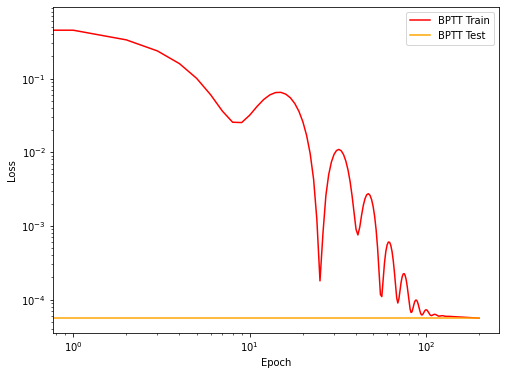

In [11]:
# Reset State & Burn-in
net(X_train_step[:,0:burn_in_period,:])

# Predict time-series via true targets
pred, _ = net(X_train_step[:,burn_in_period:,:])

# Compute loss
loss_test = criterion(pred[-1,:,:].view(-1), Y_train[burn_in_period:]).detach().numpy()
print(loss_test)

plot_loss_history(loss_train, loss_test)

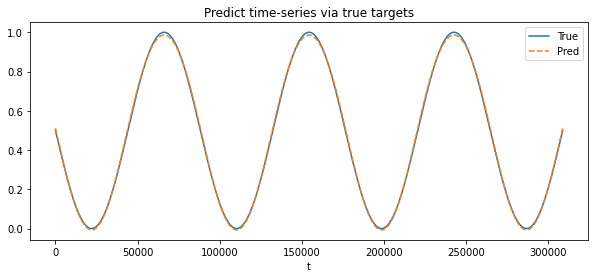

In [12]:
def plot_time_series(true, pred, label):
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(111)
    ax.plot(true, label="True", linestyle='solid')
    ax.plot(pred, label="Pred", linestyle='dashed')
    ax.set_xlabel("t")
    ax.legend(loc=1)
    ax.set_title(label)
    plt.show()

plot_time_series(X[burn_in_period+q:], pred[-1,:,:].view(-1).detach().numpy(), "Predict time-series via true targets")

## Forecasting the time-series with a seed input

0.2956153667318926


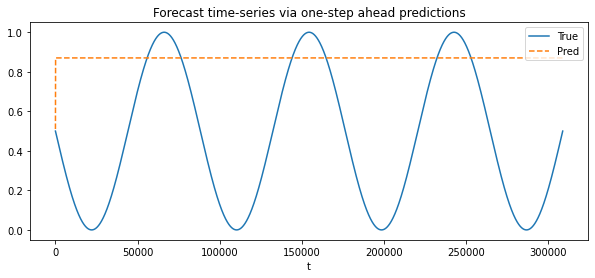

In [13]:
def one_step_ahead(net, data, n_predictions):
    lookback = q
    """
    Generally, time series forecasting describes predicting the observation at the next time step. This is called a one-step forecast.
    The recursive strategy involves using a one-step model multiple times where the prediction for the prior time step is used as an input for making a prediction on the following time step.
    """
    pred = []
    for _ in range(n_predictions):
        y_t, _ = net.forward(data)
        data[0:lookback-1,:,:] = data[1:lookback,:,:].clone()
        data[lookback-1,:,:] = y_t[lookback-1,:,:]
        pred.append(data.detach().numpy()[-1,0,0])
    return pred

# Reset State & Burn-in
net(X_train_step[:,0:burn_in_period,:])

# If ss enabled then reset teacher_forcing_ratio i.e probability for generatimg the next input
if enable_ss:
    net.teacher_forcing_ratio = 0

# Forecast time-series via one-step ahead predictions
data = X_train_step[0:q,0+burn_in_period:1+burn_in_period,:]
one_step = one_step_ahead(net, data, X_train_step[:,burn_in_period:,:].shape[1])
one_step = np.asarray(one_step)

# Compute loss
loss_forecast = criterion(torch.from_numpy(one_step), Y_train[burn_in_period:]).detach().numpy()
print(loss_forecast)

# Plot predictions
plot_time_series(X[burn_in_period+q:], one_step, "Forecast time-series via one-step ahead predictions")

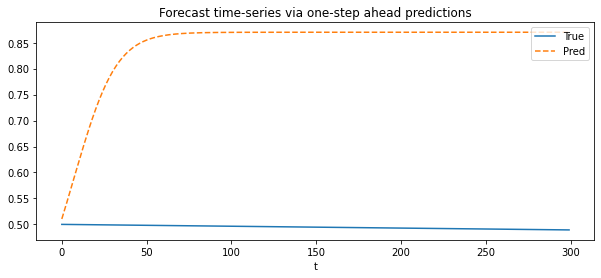

In [14]:
# Plot predictions
len = 300
plot_time_series(X[burn_in_period+q:burn_in_period+q+len], one_step[0:len], "Forecast time-series via one-step ahead predictions")